In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import nnm_for_nnfs.utils.utils_kernels as KT 
import utils.utils_density as utils
import utils.utils_data_generator as generators

In [1]:
#path to saved tensors
pt_path = "Experiments/tensors/"
fig_path = "Experiments/figures/"
csv_pat = "Experiments/tables/"

In [2]:
# Number of data points we will be using and basic parameters of the model
ndata = 50
# data generator : gaussian mixture
density_fun = generators.generateGaussianMixture([-1,1],[0.3,0.3],1)[1]
def gen(n=ndata):
    ds,_ = generators.generateGaussianMixture([-1,1],[0.3,0.3],n)
    return ds.view(n,1)

d = 1

base = 'gaussian'
mu_base,eta_base = torch.zeros((d,)),5

data_set = gen()
data_path = pt_path + 'xdataExperiments.pt'
torch.save(data_set,data_path)

def data_split(data_set,r=0.5):
    n = data_set.size(0)
    l = np.array(range(n))
    np.random.shuffle(l)
    data_set = data_set[l,:]
    del l
    ntr = int(np.ceil(n*r))
    nts = n - ntr
    data_set_train = data_set[:ntr,:]
    data_set_test = data_set[ntr:,:]
    return data_set_train,data_set_test

    

def loglikelihood(px,eps = 0,ntest=ndata,data_set_test = None):
    #Here eps is the moreau smoothing parameter
    if isinstance(data_set_test ,type(None)):
        xtest = gen(ntest)
    else:
        xtest = data_set_test
        ntest = xtest.size(0)
    p = px(xtest)
    if eps == 0:
        if (p<=0).sum() > 0:
            return torch.tensor(np.inf)
        else:
            return -(torch.log(p)).mean()
    else:
        LL = utils.loglossNW(eps/ntest)
        res = LL.Leps(p)/ntest
    return res

def squareloss(px,data_set_test = None,ntest = 0,ntestbis = 3000):
    if isinstance(data_set_test ,type(None)):
        xtest = gen(ntest)
    else:
        xtest = data_set_test
        ntest = xtest.size(0)
    if xtest.ndim == 1:
        xtest = xtest.view(ntest,1)
    d = xtest.size(1)
    center = xtest.mean(0)
    print(center)
    width = 2*(xtest - center.unsqueeze(0)).abs().max()
    print(width)
    volume = (2*width)**d
    xtestbis = center.unsqueeze(0) + 2*width*torch.rand((ntestbis,d)) - width
    T2 = px(xtest).sum()/ntest
    T1 = volume*(px(xtestbis)**2).sum()/ntestbis
    return T1-2*T2
    
    
    

NameError: name 'generators' is not defined

# Linear model

In [4]:
def makepx(data_set,la,sigma = 1,Niter = None):
    lmodel = utils.LMK(sigma,data_set,kernel = 'gaussian',centered = False,c = 0,base = base,mu_base = mu_base,eta_base = eta_base,useGPU = False,nmax_gpu = None,target_norm = 1)
    regmodel = utils.Sreg(la)
    dModel = utils.densityModel(regmodel,lmodel)
    if isinstance(Niter,type(None)):
        Niter = 100
    freq = Niter//5
    cb,cobj = dModel.cbcboj_pd(freq,plot = False)
    al = dModel.prox_method(Niter,cb = cb,cobj = cobj)
    def pxx(x):
        return dModel.px_dual(al,x)
    return pxx

## Finding the best $\lambda$ 

tensor(1.)
tensor(1.)
tensor([[-214.8735]])
tensor(10.7437)
tensor([[-195.3395]])
tensor(10.7437)
tensor([[-177.5814]])
tensor(10.7437)
tensor([[-161.4376]])
tensor(10.7437)
tensor([[-146.7615]])
tensor(10.7437)
tensor([[-133.4195]])
tensor(10.7437)
tensor([[-121.2905]])
tensor(10.7437)
tensor([[-110.2641]])
tensor(10.7437)
tensor([[-100.2401]])
tensor(10.7437)
tensor([[-91.1273]])
tensor(10.7437)
tensor([[-82.8430]])
tensor(10.7437)
tensor([[-75.3119]])
tensor(10.7437)
tensor([[-68.4653]])
tensor(10.7437)
tensor([[-62.2412]])
tensor(10.7437)
tensor([[-56.5829]])
tensor(10.7437)
tensor([[-51.4390]])
tensor(10.7437)
tensor([[-46.7627]])
tensor(10.7437)
tensor([[-42.5116]])
tensor(10.7437)
tensor([[-38.6469]])
tensor(10.7437)
tensor([[-35.1335]])
tensor(10.7437)
tensor([[-31.9396]])
tensor(10.7437)
tensor([[-29.0360]])
tensor(10.7437)
tensor([[-26.3963]])
tensor(10.7437)
tensor([[-23.9967]])
tensor(10.7437)
tensor([[-21.8152]])
tensor(10.7437)
tensor([[-19.8320]])
tensor(10.7437)
---iter

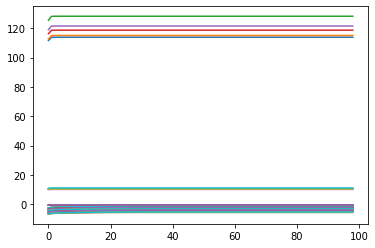

In [5]:
la_list = [1,0.1,0.01,0.001,0.0001,1e-5,1e-6,1e-7]
sigma_l = [0.1]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((3,NN))
res[1:,:] = torch.tensor(param_list).T

r = 0.7
K = 5
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[1,i],res[2,i]
        px = makepx(data_set_train,la,sigma = sigma)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
    res[0,i]/= K




In [48]:
#torch.save(res,pt_path + 'lambda_choice_linear1.pt')

lambda
tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04, 1.0000e-05,
        1.0000e-06, 1.0000e-07])
sigma
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000])


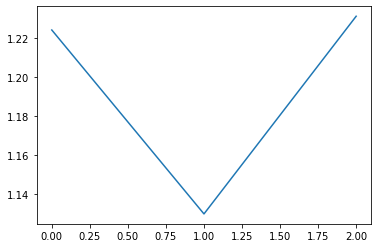

In [50]:
path_la_choice = pt_path + 'lambda_choice_linear1.pt'
res = torch.load(path_la_choice)

print("lambda")
print(res[1,:])
print("sigma")
print(res[2,:])

NN = res.size(1)

plt.figure()
#plt.ylim(-10,10)

plt.plot(range(NN),res[0,:])
plt.show()

## Performing the test 

---iteration: 1---
---iteration: 401---
---iteration: 801---
---iteration: 1201---
---iteration: 1601---


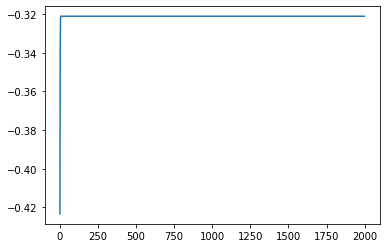

In [51]:
data_set = torch.load(data_path)
ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 0.1
px = makepx(data_set,la,sigma = 1,Niter = 2000)

In [52]:
c,r,ntest = 0,10,100000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
ytest = px(xtest)
#print(ytest.sum()*(2*r)**d/ntest)
ydata_set = px(data_set)


torch.save(xtest,pt_path+'xtest_linear1.pt')
torch.save(ytest,pt_path+'ytest_linear1.pt')
torch.save(ydata_set,pt_path+'ydata_linear1.pt')

#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')



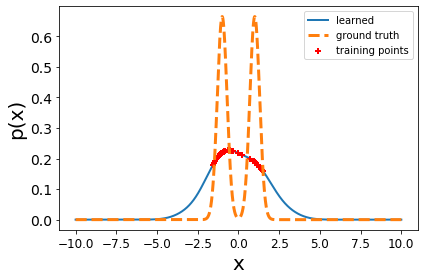

In [53]:
xtest = torch.load(pt_path+'xtest_linear1.pt')
ytest = torch.load(pt_path+'ytest_linear1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_linear1.pt')


#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


ytestref = density_fun(xtest)



fig = plt.figure()
plt.plot(xtest,ytest,lw = 2,label='learned',zorder = -1)
plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig('linearPlot0density.pdf' , format='pdf', dpi=1000)
plt.show()

# Our model

In [22]:
def makepx(data_set,la,sigma = 1,Niter = 1000):
    lmodel =  utils.QKM(sigma,data_set,kernel = 'gaussian',centered = False,c = 0,base = base,mu_base = mu_base,eta_base = eta_base,target_norm = np.sqrt(la*0.01))
    regmodel = utils.ENreg(la,la*0.01)
    dModel = utils.densityModel(regmodel,lmodel)
    freq = Niter // 5
    #cb,cobj = dModel.cbcboj_pd(freq,plot = False)
    al = dModel.prox_method(Niter)
    def pxx(x):
        return dModel.px_dual(al,x)
    return pxx


lambda = 1.0,sigma = 1.0
tensor(1.4567)
lambda = 1.0,sigma = 1.0
tensor(1.4901)
lambda = 1.0,sigma = 1.0
tensor(1.4644)
lambda = 1.0,sigma = 1.0
tensor(1.4657)
lambda = 1.0,sigma = 1.0
tensor(1.4753)
lambda = 0.1,sigma = 1.0
tensor(1.3087)
lambda = 0.1,sigma = 1.0
tensor(1.3329)
lambda = 0.1,sigma = 1.0
tensor(1.3443)
lambda = 0.1,sigma = 1.0
tensor(1.3116)
lambda = 0.1,sigma = 1.0
tensor(1.3088)
lambda = 0.01,sigma = 1.0
tensor(0.9855)
lambda = 0.01,sigma = 1.0
tensor(0.8996)
lambda = 0.01,sigma = 1.0
tensor(0.9080)
lambda = 0.01,sigma = 1.0
tensor(0.8857)
lambda = 0.01,sigma = 1.0
tensor(0.9611)
lambda = 0.001,sigma = 1.0
tensor(0.9040)
lambda = 0.001,sigma = 1.0
tensor(0.8861)
lambda = 0.001,sigma = 1.0
tensor(0.8645)
lambda = 0.001,sigma = 1.0
tensor(0.9282)
lambda = 0.001,sigma = 1.0
tensor(0.9083)
lambda = 0.0001,sigma = 1.0
tensor(0.8651)
lambda = 0.0001,sigma = 1.0
tensor(0.8467)
lambda = 0.0001,sigma = 1.0
tensor(0.7313)
lambda = 0.0001,sigma = 1.0
tensor(0.9395)
lambda = 0.00

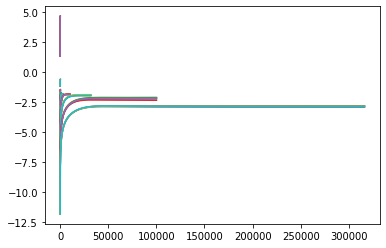

In [32]:
la_list = [1,0.1,0.01,0.001,0.0001,1e-5,1e-6,1e-7,1e-8,1e-9]
sigma_l = [1]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((3,NN))
res[1:,:] = torch.tensor(param_list).T

r = 0.7
K = 5
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[1,i],res[2,i]
        px = makepx(data_set_train,la,sigma = sigma,Niter = 100 + 10*int(1/np.sqrt(la)))
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,eps = 0.0001,data_set_test=data_set_test)
        #ll = l2distance(px)
        print(ll)
        res[0,i] += ll
    res[0,i]/= K

In [33]:
torch.save(res,pt_path + 'lambda_choice_ours1.pt')

lambda
tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04, 1.0000e-05,
        1.0000e-06, 1.0000e-07, 1.0000e-08, 1.0000e-09])
sigma
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


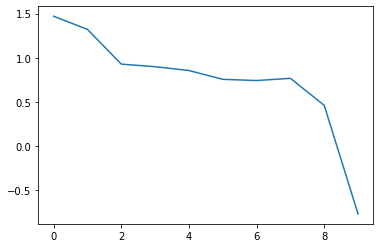

In [34]:
path_la_choice = pt_path + 'lambda_choice_ours1.pt'
res = torch.load(path_la_choice)

print("lambda")
print(res[1,:])
print("sigma")
print(res[2,:])

NN = res.size(1)

plt.figure()
plt.plot(range(NN),res[0,:])
plt.show()

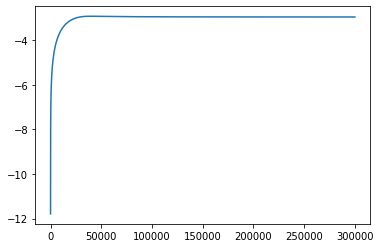

In [35]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 1e-9
px = makepx(data_set,la,sigma = 1,Niter = 300000)

In [36]:
c,r,ntest = 0,4,10000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
ytest = px(xtest)
#print(ytest.sum()*(2*r)**d/ntest)
ydata_set = px(data_set)


torch.save(xtest,pt_path+'xtest_ours1.pt')
torch.save(ytest,pt_path+'ytest_ours1.pt')
torch.save(ydata_set,pt_path+'ydata_ours1.pt')

#torch.save(xtest,pt_path+'xtest_ours0.pt')
#torch.save(ytest,pt_path+'ytest_ours0.pt')
#torch.save(ydata_set,pt_path+'ydata_ours0.pt')





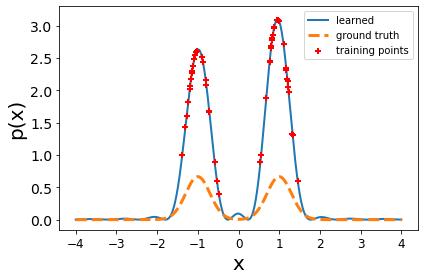

In [37]:
xtest = torch.load(pt_path+'xtest_ours1.pt')
ytest = torch.load(pt_path+'ytest_ours1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_ours1.pt')


#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


ytestref = density_fun(xtest)



fig = plt.figure()
plt.plot(xtest,ytest,lw = 2,label='learned',zorder = -1)
plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig('linearPlot0density.pdf' , format='pdf', dpi=1000)
plt.show()

# Nadaraya Watson

In [16]:
def makepx(data_set,la,sigma =1,Niter = 1000):
    kmodel = utils.kernelModel(sigma,data_set,kernel = 'gaussian',c = 0,base = base,mu_base = mu_base,eta_base = eta_base)
    dm = utils.densityModelNW(kmodel,la,eps = 0.001)
    al = dm.FISTA(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx

lambda = 1.0,sigma = 0.2
tensor(1.9746)
lambda = 1.0,sigma = 0.2
tensor(1.9809)
lambda = 1.0,sigma = 0.2
tensor(1.9908)
lambda = 1.0,sigma = 0.2
tensor(2.0006)
lambda = 1.0,sigma = 0.2
tensor(2.0042)
lambda = 0.1,sigma = 0.2
tensor(1.6724)
lambda = 0.1,sigma = 0.2
tensor(1.5097)
lambda = 0.1,sigma = 0.2
tensor(1.5927)
lambda = 0.1,sigma = 0.2
tensor(1.3922)
lambda = 0.1,sigma = 0.2
tensor(1.7723)
lambda = 0.01,sigma = 0.2
tensor(0.7882)
lambda = 0.01,sigma = 0.2
tensor(0.8434)
lambda = 0.01,sigma = 0.2
tensor(0.6355)
lambda = 0.01,sigma = 0.2
tensor(0.7967)
lambda = 0.01,sigma = 0.2
tensor(-0.2341)
lambda = 0.001,sigma = 0.2
tensor(2.0238)
lambda = 0.001,sigma = 0.2
tensor(0.5828)
lambda = 0.001,sigma = 0.2
tensor(0.2212)
lambda = 0.001,sigma = 0.2
tensor(-0.1328)
lambda = 0.001,sigma = 0.2
tensor(0.9575)
lambda = 0.0001,sigma = 0.2
tensor(-1.2288)
lambda = 0.0001,sigma = 0.2
tensor(1.7054)
lambda = 0.0001,sigma = 0.2
tensor(-1.3832)
lambda = 0.0001,sigma = 0.2
tensor(2.3057)
lambda = 

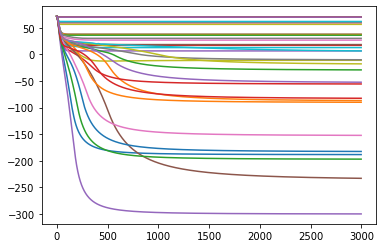

In [21]:
la_list = [1,0.1,0.01,0.001,0.0001,1e-5,1e-6]
sigma_l = [0.2]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((3,NN))
res[1:,:] = torch.tensor(param_list).T

r = 0.7
K = 5
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[1,i],res[2,i]
        px = makepx(data_set_train,la,sigma = sigma)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,eps = 0.0001,data_set_test=data_set_test)
        #ll = l2distance(px)
        print(ll)
        res[0,i] += ll
    res[0,i]/= K

In [22]:
torch.save(res,pt_path + 'lambda_choice_NW0.pt')

lambda
tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04, 1.0000e-05,
        1.0000e-06])
sigma
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


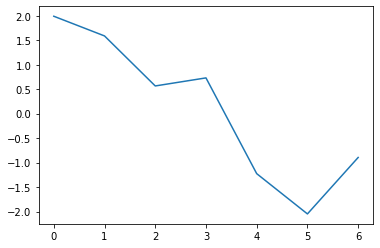

In [23]:
path_la_choice = pt_path + 'lambda_choice_NW0.pt'
res = torch.load(path_la_choice)

print("lambda")
print(res[1,:])
print("sigma")
print(res[2,:])

NN = res.size(1)

plt.figure()
plt.plot(range(NN),res[0,:])
plt.show()

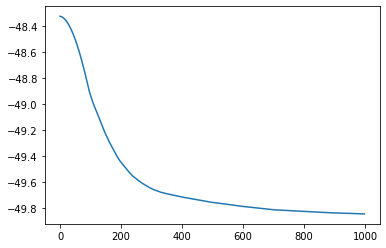

In [17]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 0.01
px = makepx(data_set,la,sigma = 1,Niter = 1000)

In [21]:
c,r,ntest = 0,5,10000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
ytest = px(xtest)
#print(ytest.sum()*(2*r)**d/ntest)
ydata_set = px(data_set)


torch.save(xtest,pt_path+'xtest_NW1.pt')
torch.save(ytest,pt_path+'ytest_NW1.pt')
torch.save(ydata_set,pt_path+'ydata_NW1.pt')

#torch.save(xtest,pt_path+'xtest_ours0.pt')
#torch.save(ytest,pt_path+'ytest_ours0.pt')
#torch.save(ydata_set,pt_path+'ydata_ours0.pt')



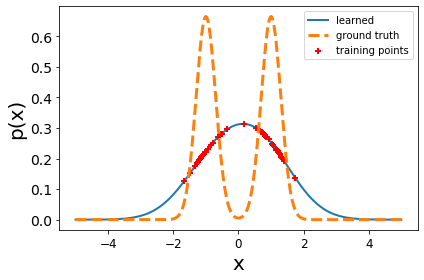

In [22]:
xtest = torch.load(pt_path+'xtest_NW1.pt')
ytest = torch.load(pt_path+'ytest_NW1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_NW1.pt')


#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


ytestref = density_fun(xtest)



fig = plt.figure()
plt.plot(xtest,ytest,lw = 2,label='learned',zorder = -1)
plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig('linearPlot0density.pdf' , format='pdf', dpi=1000)
plt.show()

# GLMS 

In [4]:
def makepx(data_set,la,sigma = 1,Niter = 300):
    kmodel = utils.kernelExpoModel(sigma,data_set,4,100,cgrid = None,kernel = 'gaussian',centered = False,c = 0,base = base,mu_base = mu_base,eta_base = eta_base)
    eps = 0.001
    dm = utils.densityModelExpo(kmodel,la,eps=eps)
    al = dm.GD(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx

lambda = 1.0,sigma = 1.0
ll = 1.940576890270186
lambda = 1.0,sigma = 1.0
ll = 1.9343383255384374
lambda = 1.0,sigma = 1.0
ll = 1.8938600335140072
lambda = 1.0,sigma = 1.0
ll = 1.9110569594395037
lambda = 1.0,sigma = 1.0
ll = 1.8911715245194165
lambda = 0.1,sigma = 1.0
ll = 1.4893162798734507
lambda = 0.1,sigma = 1.0
ll = 1.4169631693565783
lambda = 0.1,sigma = 1.0
ll = 1.5724309851868037
lambda = 0.1,sigma = 1.0
ll = 1.3798540831939858
lambda = 0.1,sigma = 1.0
ll = 1.4397487345828244
lambda = 0.01,sigma = 1.0
ll = 1.400747701970616
lambda = 0.01,sigma = 1.0
ll = 1.3391218723481242
lambda = 0.01,sigma = 1.0
ll = 0.7105867689228781
lambda = 0.01,sigma = 1.0
ll = 1.0025680263775159
lambda = 0.01,sigma = 1.0
ll = 1.1547035656842641
lambda = 0.001,sigma = 1.0
ll = 0.7450791920821905
lambda = 0.001,sigma = 1.0
ll = 1.069312415273717
lambda = 0.001,sigma = 1.0
ll = 1.086799120446124
lambda = 0.001,sigma = 1.0
ll = 1.1689262846446542


KeyboardInterrupt: 

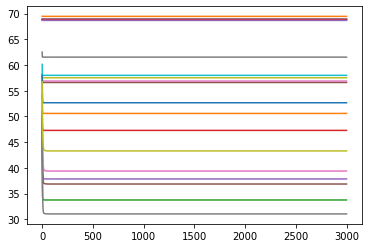

In [5]:
la_list = [1,0.1,0.01,0.001,0.0001,1e-5,1e-6,1e-7]
sigma_l = [1]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((3,NN))
res[1:,:] = torch.tensor(param_list).T

r = 0.7
K = 5
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[1,i],res[2,i]
        px = makepx(data_set_train,la,sigma = sigma)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,eps = 0.0001,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
    res[0,i]/= K





In [6]:
torch.save(res,pt_path + 'lambda_choice_GLM0.pt')


lambda
tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04, 1.0000e-05,
        1.0000e-06, 1.0000e-07])
sigma
tensor([1., 1., 1., 1., 1., 1., 1., 1.])


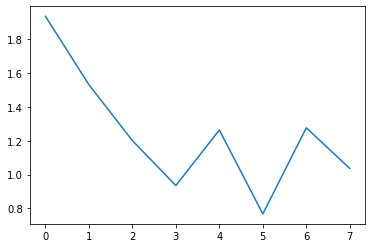

In [12]:
path_la_choice = pt_path + 'lambda_choice_GLM0.pt'
res = torch.load(path_la_choice)

print("lambda")
print(res[1,:])
print("sigma")
print(res[2,:])

NN = res.size(1)

plt.figure()
plt.plot(range(NN),res[0,:])
plt.show()

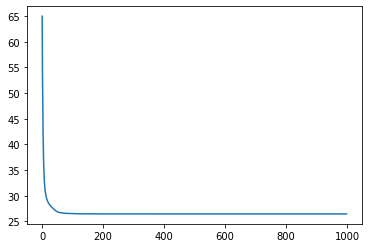

In [7]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 0.0001
px = makepx(data_set,la,sigma = 1,Niter = 1000)

In [8]:
c,r,ntest = 0,5,10000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
ytest = px(xtest)
#print(ytest.sum()*(2*r)**d/ntest)
ydata_set = px(data_set)


torch.save(xtest,pt_path+'xtest_GLM1.pt')
torch.save(ytest,pt_path+'ytest_GLM1.pt')
torch.save(ydata_set,pt_path+'ydata_GLM1.pt')

#torch.save(xtest,pt_path+'xtest_ours0.pt')
#torch.save(ytest,pt_path+'ytest_ours0.pt')
#torch.save(ydata_set,pt_path+'ydata_ours0.pt')



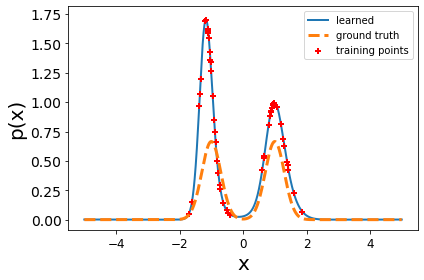

In [9]:
xtest = torch.load(pt_path+'xtest_GLM1.pt')
ytest = torch.load(pt_path+'ytest_GLM1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_GLM1.pt')


#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


ytestref = density_fun(xtest)



fig = plt.figure()
plt.plot(xtest,ytest,lw = 2,label='learned',zorder = -1)
plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig('linearPlot0density.pdf' , format='pdf', dpi=1000)
plt.show()

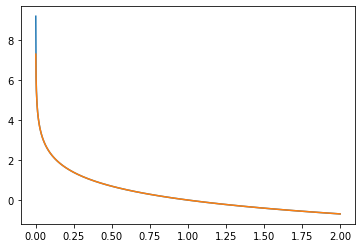

In [7]:
l = lambda x : -torch.log(x)
proxl = lambda x,c : 0.5*(x+torch.sqrt(x**2 + 4*c))
leps = lambda x,eps : l(proxl(x,eps)) + (proxl(x,eps)-x)**2/(2*eps)
xt = torch.linspace(0.0001,2,1000)
plt.plot(xt,l(xt))
plt.plot(xt,leps(xt,0.000001))
plt.show()